In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [202]:
def read_data(adr, y_name):
    df = pd.read_csv(adr)
    x = df.loc[:, df.columns != y_name]
    y = df.loc[:, df.columns == y_name]
    return x, y

x, y = read_data('heart.csv', 'target')
x.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2


In [11]:
y.head()

,target
0,1
1,1
2,1
3,1
4,1


In [203]:
def shuffle(x, y):
    idx = np.random.permutation(x.index)
    x = x.reindex(idx)
    y = y.reindex(idx)
    return x, y

x, y = shuffle(x, y)
x.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
172,58,1,1,120,284,0,0,160,0,1.8,1,0,2
271,61,1,3,134,234,0,1,145,0,2.6,1,2,2
91,57,1,0,132,207,0,1,168,1,0.0,2,0,3
36,54,0,2,135,304,1,1,170,0,0.0,2,0,2
104,50,1,2,129,196,0,1,163,0,0.0,2,0,2


In [13]:
y.head()

,target
115,1
6,1
87,1
52,1
94,1


In [204]:
def data_split(x, y, frac):
    idx = np.random.permutation(x.index)
    train_idx = idx[:int(len(idx) * frac)]
    test_idx = idx[int(len(idx) * frac):len(idx)]
    
    train_x = x.iloc[train_idx, :]
    train_y = y.iloc[train_idx, :]
    test_x = x.iloc[test_idx, :]
    test_y = y.iloc[test_idx, :]
   
    return train_x, train_y, test_x, test_y

train_x, train_y, test_x, test_y = data_split(x, y, 0.8)    

In [16]:
def accuracy(y, y_pred):
    diff = (y == y_pred).to_numpy()
    return np.count_nonzero(diff) / len(y)

accuracy(test_y, test_y)

1.0

In [75]:
def confusion_matrix(y, y_pred):
    tp = np.count_nonzero((y_pred == True) & (y == True).to_numpy())
    fp = np.count_nonzero((y_pred == True) & (y == False).to_numpy())
    tn = np.count_nonzero((y_pred == False) & (y == False).to_numpy())
    fn = np.count_nonzero((y_pred == False) & (y == True).to_numpy()) 
    return tp, fp, tn, fn

confusion_matrix(test_y, test_y)

(36, 0, 25, 0)

In [18]:
def classification_report(y, y_pred):
    tp, fp, tn, fn = confusion_matrix(y, y_pred)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    specificity = tn / (tn + fp)
    f1_score = 2 * recall * precision / (recall + precision)
    return accuracy, recall, precision, specificity, f1_score  

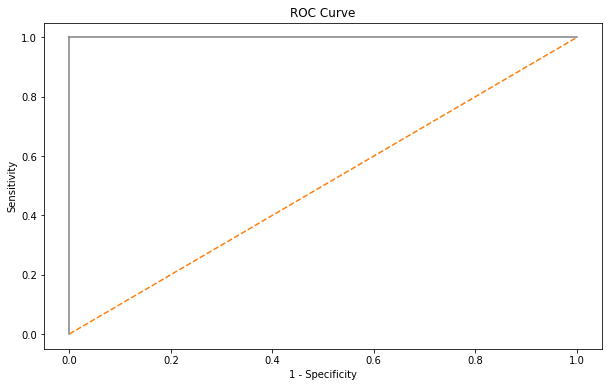

In [19]:
def roc_curve(y, y_pred):
    tp, fp, tn, fn = confusion_matrix(y, y_pred)
    plt.figure(figsize=(10,6))
    sen = tp / (tp + fn)
    spe = tn / (tn + fp)
    plt.title('ROC Curve')
    plt.xlabel('1 - Specificity')
    plt.ylabel('Sensitivity')
    plt.plot(1 - spe, sen)
    plt.plot([0,1], ls='--')
    plt.plot([0,0],[1,0], c='.5')
    plt.plot([1,1], c='.5')
    plt.show()
    return

roc_curve(test_y, test_y)

In [21]:
def t_test(y1, y2, threshold):
    mean1 = np.mean(y1)
    mean2 = np.mean(y2)
    # do we need ddof =1 here in std?
    std1 = np.std(y1)
    std2 = np.std(y2)
    t_stat = (mean1 - mean2) / np.sqrt(std1**2 / len(y1) + std2**2 / len(y2))
    # compute p_value and reject or accept null hypotesis
    # https://machinelearningmastery.com/how-to-code-the-students-t-test-from-scratch-in-python/
    # https://towardsdatascience.com/hypothesis-testing-in-machine-learning-using-python-a0dc89e169ce   
    print(mean1, std1, t_stat)
    return

t_test(test_y, test_y, 0.8)

target    0.590164
dtype: float64 target    0.491803
dtype: float64 target    0.0
dtype: float64


In [177]:
class KNN:
  def __init__(self, k):
    self.k = k
    
  def predict(self, test_x):
    test_x = self.scale_features(test_x)
    test_pred = pd.DataFrame(columns = ['target'], index = test_x.index)
    
    for i in range(0, len(test_x)):
        neighbor_indexes = self.find_neighbors(self.x, self.y, test_x.iloc[i], self.k) 
        majority = self.y.iloc[neighbor_indexes].mode()
        test_pred.at[test_x.index[i], 'target'] = majority.at[0, 'target']

    return test_pred

  def euclidean_distance(self, v1, v2):
    dif = v1 - v2
    return np.sqrt(np.sum(dif ** 2))

  def scale_features(self, x):
    x_min, x_max = x.min(), x.max()
    return (x - x_min) / (x_max - x_min)

  def find_neighbors(self, x, y, test_row, k):
    dist = np.zeros(len(x))
    for i in range(0, len(x)):
        dist[i] = self.euclidean_distance(x.iloc[i], test_row)
    indexes = dist.argsort()[0:k]
    return indexes 

  def fit(self, x, y):
    self.x = self.scale_features(x)
    self.y = y


for i in range(1, 15):
    k1 = KNN(i)
    k1.fit(train_x, train_y)
    test_pred = k1.predict(test_x)
    test_pred.set_index(test_x.index)
    print(accuracy(test_pred, test_y))
    train_pred = k1.predict(train_x)
    train_pred.set_index(train_x.index)
    print(accuracy(train_pred, train_y), "\n\n")


0.7868852459016393
1.0 


0.8032786885245902
0.871900826446281 


0.8852459016393442
0.8677685950413223 


0.9016393442622951
0.8471074380165289 


0.9344262295081968
0.8429752066115702 


0.9180327868852459
0.8471074380165289 


0.9016393442622951


KeyboardInterrupt: 

In [207]:
class Node:
    def __init__(self, pred):
        self.left_child = None
        self.right_child = None
        self.feature = None
        self.pred = pred
        self.bound = 0

class DecisionTree:
  def __init__(self, max_depth, threshold):
    self.max_depth = max_depth
    self.threshold = threshold
    
  def fit(self, x, y):
    self.tree = self.build_tree(x, y, 0) 
    
  def impurity(self, a, b):
    return 1.0 - (a / (a + b)) ** 2 - (b / (a + b)) ** 2
    
  def split(self, x, y):
    best_feature = None
    bound = None
    
    split_count = [y.target.value_counts()[0], y.target.value_counts()[1]]
    best_impurity = self.impurity(split_count[0], split_count[1])
    
    for feature in range(0, x.shape[1]):
        left_split_count = [0, 0]
        right_split_count = split_count.copy()
        x_numpy = x.copy().iloc[:, feature].to_numpy()
        y_numpy = y.copy().iloc[:, 0].to_numpy()  
        x_sorted, y_sorted = zip(*sorted(zip(x_numpy, y_numpy)))
        
        for i in range(1, x.shape[0]):
            target = y_sorted[i - 1]
            left_split_count[target] += 1
            right_split_count[target] -= 1
            
            if x_sorted[i] == x_sorted[i - 1]:
                continue
                
            impurity_left = self.impurity(left_split_count[0], left_split_count[1])
            impurity_right = self.impurity(right_split_count[0], right_split_count[1])
            impurity_total = (i * impurity_left + (x.shape[0] - i) * impurity_right) / x.shape[0]
                
            if impurity_total < best_impurity:
                best_impurity = impurity_total
                best_feature = feature
                bound = (x_sorted[i] + x_sorted[i - 1]) / 2  
    
    return bound, best_feature

  def build_tree(self, x, y, depth):
    node = Node(pred = y.mode().at[0, 'target'])
    
    if y.target.value_counts().size == 1:
        return node
            
    if depth < self.max_depth and y.target.value_counts()[0] < self.threshold * y.shape[0]:
        bound, feature = self.split(x, y)
        if feature is not None:
            node.feature = feature
            node.bound = bound
            division = x.iloc[:, feature] < bound
            left_x = x[division]
            right_x = x[~division]
            left_y = y[division]
            right_y = y[~division]           
            node.left_child = self.build_tree(left_x, left_y, depth + 1)
            node.right_child = self.build_tree(right_x, right_y, depth + 1)           

    return node
    
  def predict(self, test_x):
    test_pred = pd.DataFrame(columns = ['target'], index = test_x.index)
    
    for i in range(0, len(test_x)):
        node = self.tree
        while node.left_child:
            if test_x.iloc[i, node.feature] < node.bound:
                node = node.left_child
            else:
                node = node.right_child
        test_pred.at[test_x.index[i], 'target'] = node.pred
    
    return test_pred
    
for i in range(1, 15):   
    d1 = DecisionTree(i, 0.8)
    d1.fit(train_x, train_y)
    test_pred = d1.predict(test_x)
    print(accuracy(test_pred, test_y))
    train_pred = d1.predict(train_x)
    print(accuracy(train_pred, train_y))

0.6885245901639344
0.7768595041322314
0.7213114754098361
0.7975206611570248
0.7540983606557377
0.859504132231405
0.7540983606557377
0.8801652892561983
0.7540983606557377
0.9049586776859504
0.8032786885245902
0.9380165289256198
0.7540983606557377
0.9586776859504132
0.7868852459016393
0.9710743801652892
0.7868852459016393
0.9710743801652892
0.7868852459016393
0.9752066115702479
0.7868852459016393
0.9752066115702479
0.7868852459016393
0.9752066115702479
0.7868852459016393
0.9752066115702479
0.7868852459016393
0.9752066115702479


In [210]:
def cross_validation(k, x, y, estimator):
    acc = np.zeros(k)
    for i in range(0, k):
        dev_set_x = x.iloc[(int)(i * len(x) / k):(int)((i + 1) * len(x) / k), :]
        dev_set_y = y.iloc[(int)(i * len(y) / k):(int)((i + 1) * len(y) / k), :]
        train_set_x = x[~x.index.isin(dev_set_x.index.tolist())]
        train_set_y = y[~y.index.isin(dev_set_y.index.tolist())]
        
        estimator.fit(train_set_x, train_set_y)
        dev_pred = estimator.predict(dev_set_x)
        acc[i] = accuracy(dev_pred, dev_set_y)
    
    # print(acc)
    return np.mean(acc)
    
def best_estimator(param_max, est_type):
    best_acc = 0.0
    best_param = 1

    for i in range(1, param_max + 1):
        e1 = None
        if est_type == "knn":
            e1 = KNN(i)
        elif est_type == "decision tree":    
            e1 = DecisionTree(i, 0.8)
        acc = cross_validation(5, train_x, train_y, e1) 
        print(i, acc)
        if acc > best_acc:
            best_param = i
            best_acc = acc

    print(best_param)
    print(best_acc)
    
    
best_estimator(15, "knn")
best_estimator(13, "decision tree")

1 0.7770408163265307
2 0.7855442176870747
3 0.8308673469387756
4 0.8184523809523808
5 0.818452380952381
6 0.8186224489795919
7 0.8142857142857143
8 0.8142857142857144
9 0.8142857142857143
10 0.7936224489795919
11 0.797704081632653
12 0.793452380952381
13 0.79328231292517
14 0.7975340136054421
15 0.79328231292517
3
0.8308673469387756
1 0.7770408163265305
2 0.764625850340136
3 0.8308673469387756
4 0.8059523809523809
5 0.785204081632653
6 0.7811224489795918
7 0.7605442176870749
8 0.7564625850340136
9 0.7564625850340136
10 0.7523809523809524
11 0.7523809523809524
12 0.7523809523809524
13 0.7523809523809524
3
0.8308673469387756


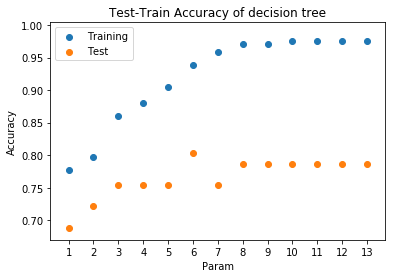

In [228]:
def chi_square_pruning():
    return

def accuracy_plot(param_max, est_type):
    train_acc = np.zeros(param_max)
    test_acc = np.zeros(param_max)
    
    for i in range(1, param_max + 1): 
        e1 = None
        if est_type == "knn":
            e1 = KNN(i)
        elif est_type == "decision tree":    
            e1 = DecisionTree(i, 0.8)
        e1.fit(train_x, train_y)
        
        test_pred = e1.predict(test_x)
        test_acc[i-1] = accuracy(test_pred, test_y)
        
        train_pred = e1.predict(train_x)
        train_acc[i-1] = accuracy(train_pred, train_y)
    
    plt.scatter(range(1, param_max + 1), train_acc, label='Training')
    plt.scatter(range(1, param_max + 1), test_acc, label='Test')
    plt.xticks(np.arange(1, param_max + 1, 1.0))

    plt.xlabel("Param")
    plt.ylabel("Accuracy")
    
    plt.legend(loc='upper left')
    plt.title("Test-Train Accuracy of " + est_type)
    plt.show()
    #print(train_acc)
    #print(test_acc)
        
#accuracy_plot(15, "knn")
accuracy_plot(13, "decision tree")        